In [36]:
import numpy as np
import pandas as pd
import scipy.signal as sps
import scipy.ndimage as spn
import scipy.stats as sts
import matplotlib.pyplot as plt
import os

In [30]:
def get_acf_period(lags, acf, cutoff=0):
    # find all the peaks
    m = lags > cutoff
    xpeaks, ypeaks = get_peak_statistics(lags[m], acf[m],
                                         sort_by="height")

    return xpeaks[0] # this is the acf period

def get_peak_statistics(x, y, sort_by="height"):

    # Array of peak indices
    peaks = np.array([i for i in range(1, len(y)-1) if y[i-1] <
                      y[i] and y[i+1] < y[i]])

    # extract peak values
    x_peaks = x[peaks]
    y_peaks = y[peaks]

    # sort by height
    if sort_by == "height":
        inds = np.argsort(y_peaks)
        x_peaks, y_peaks = x_peaks[inds][::-1], y_peaks[inds][::-1]

    # sort by position
    elif sort_by == "position":
        inds = np.argsort(x_peaks)
        x_peaks, y_peaks = x_peaks[inds], y_peaks[inds]

    return x_peaks, y_peaks

def process(filename, method='savgol', param=99):
    
    f = pd.read_csv(filename, header=None)
    
    lags = np.asarray(f[0])
    acf = np.asarray(f[1])
    N = len(acf)
    double_acf, double_lags = [np.zeros((2*N)) for i in range(2)]
    double_acf[:N], double_lags[:N] = acf[::-1], -lags[::-1]
    double_acf[N:], double_lags[N:] = acf, lags
    acf, lags = double_acf, double_lags
    
    if method == 'savgol': # 3rd order savitsky golay filter; param is window length
        acf_smooth = sps.savgol_filter(acf, param, 3)
    elif method == 'gauss': # gaussian filter; param is width
        acf_smooth = spn.gaussian_filter(acf, sigma=param)
    
    acf_smooth, lags = acf_smooth[N:], lags[N:]
    
    return get_acf_period(lags, acf_smooth)

def plot_three(periods1, periods2, periods3, groundtruths, method, param):
    
    fig, ax = plt.subplots(1,3, figsize=(10,4), constrained_layout=True)

    ax[0].scatter(periods1, groundtruths, s=5)
    ax[1].scatter(periods2, groundtruths, s=5)
    ax[2].scatter(periods3, groundtruths, s=5)

    ax[0].set(xlabel='Kepler Q9 period (d)', ylabel='McQuillan 14 period (d)')
    ax[1].set(xlabel='TESSify period (d)', title=f'{method} {param}')
    ax[2].set(xlabel='filtered TESSify period (d)')

    plt.savefig(f'acftest_{method}{param}.png')
    plt.close()

In [3]:
wd = os.getcwd()

In [9]:
os.chdir(wd)

In [4]:
rotators = pd.read_csv('M14rotators.csv')

kic_r = rotators['KIC']
p_r = rotators['Prot']

## optimisation:

In [43]:
os.chdir(wd)

params = np.arange(0,25)
chi2k = np.zeros(len(params))
chi2t1 = np.zeros(len(params))
chi2t2 = np.zeros(len(params))

for j, p in enumerate(params):

    periods_k = []
    periods_t1 = []
    periods_t2 = []
    
    for i, k in enumerate(kic_r):

        os.chdir('./acfs')

        periods_k.append(process(f'KIC{k}_kep_acf.csv', method='gauss', param=p))
        periods_t1.append(process(f'KIC{k}_tess1_acf.csv', method='gauss', param=p))
        periods_t2.append(process(f'KIC{k}_tess2_acf.csv', method='gauss', param=p))

        os.chdir(wd)
    
    chi2k[j], dump = sts.chisquare(periods_k, p_r)
    chi2t1[j], dump = sts.chisquare(periods_t1, p_r)
    chi2t2[j], dump = sts.chisquare(periods_t2, p_r)

<IPython.core.display.Javascript object>


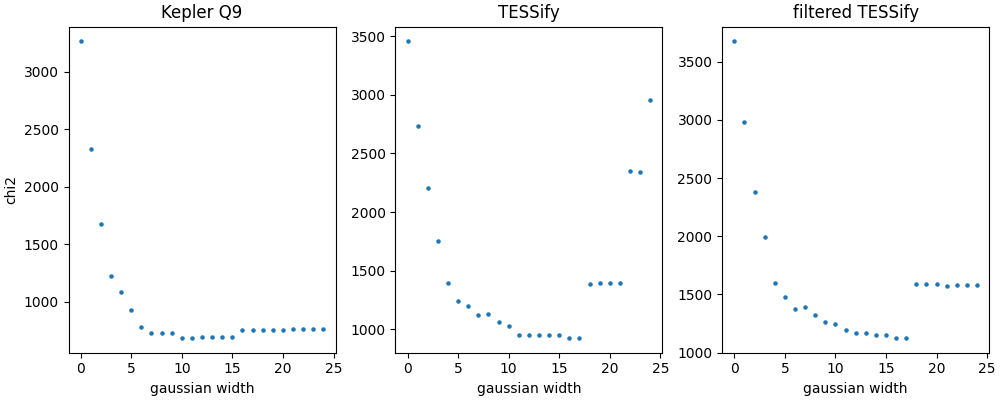

[Text(0.5, 1.0, 'filtered TESSify'), Text(0.5, 0, 'gaussian width')]

In [45]:
%matplotlib notebook

fig, ax = plt.subplots(1,3, figsize=(10,4), constrained_layout=True)

ax[0].scatter(params, chi2k, s=5)
ax[1].scatter(params, chi2t1, s=5)
ax[2].scatter(params, chi2t2, s=5)

ax[0].set(title='Kepler Q9', xlabel='gaussian width', ylabel='chi2')
ax[1].set(title='TESSify', xlabel='gaussian width')
ax[2].set(title='filtered TESSify', xlabel='gaussian width')

## second test, with plots:

<IPython.core.display.Javascript object>


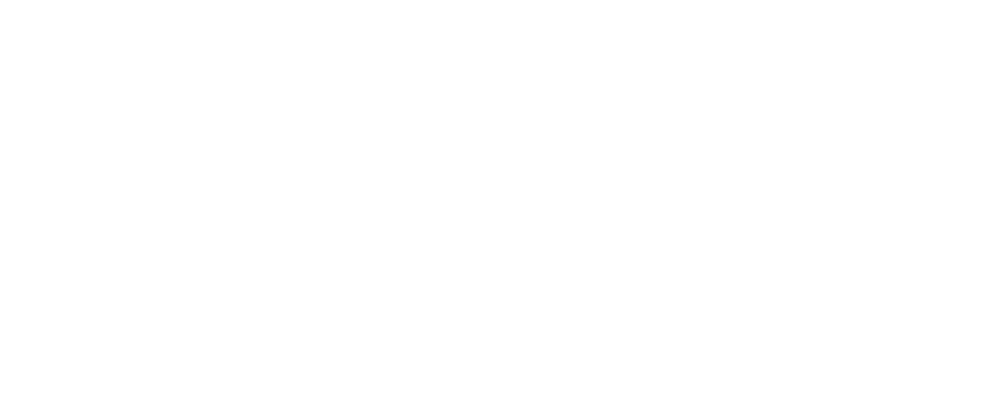

<IPython.core.display.Javascript object>


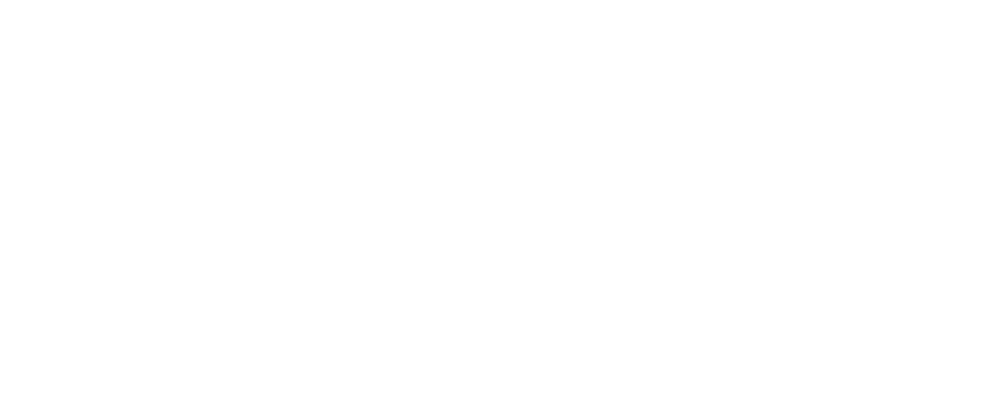

<IPython.core.display.Javascript object>


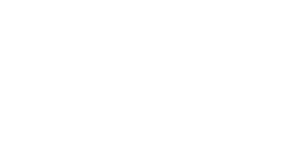

<IPython.core.display.Javascript object>


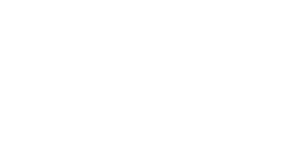

<IPython.core.display.Javascript object>


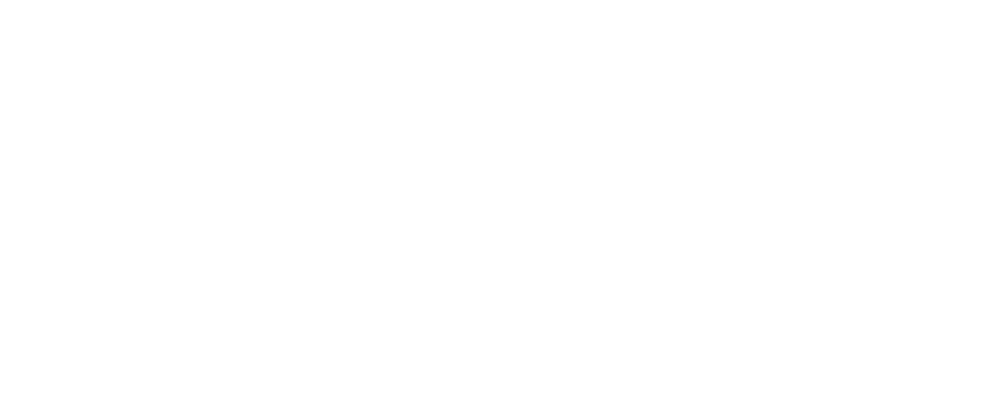

<IPython.core.display.Javascript object>


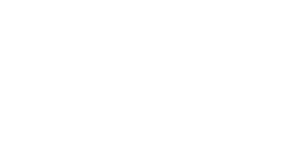

<IPython.core.display.Javascript object>


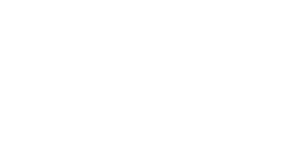

In [35]:
os.chdir(wd)

methods = ['savgol', 'savgol', 'savgol', 'gauss', 'gauss', 'gauss', 'gauss']
params = [99, 41, 11, 15, 5, 56, 30]

for j in range(len(methods)):

    periods_k = []
    periods_t1 = []
    periods_t2 = []
    
    for i, k in enumerate(kic_r):

        os.chdir('./acfs')

        periods_k.append(process(f'KIC{k}_kep_acf.csv', method=methods[j], param=params[j]))
        periods_t1.append(process(f'KIC{k}_tess1_acf.csv', method=methods[j], param=params[j]))
        periods_t2.append(process(f'KIC{k}_tess2_acf.csv', method=methods[j], param=params[j]))

        os.chdir(wd)

    plot_three(periods_k, periods_t1, periods_t2, p_r, methods[j], params[j])

## test version:

In [5]:
os.chdir(wd)

periods_k = []
periods_t1 = []
periods_t2 = []

for i, k in enumerate(kic_r):
    
    os.chdir('./acfs')
    
    periods_k.append(process(f'KIC{k}_kep_acf.csv'))
    periods_t1.append(process(f'KIC{k}_tess1_acf.csv'))
    periods_t2.append(process(f'KIC{k}_tess2_acf.csv'))
    
    os.chdir(wd)

<IPython.core.display.Javascript object>


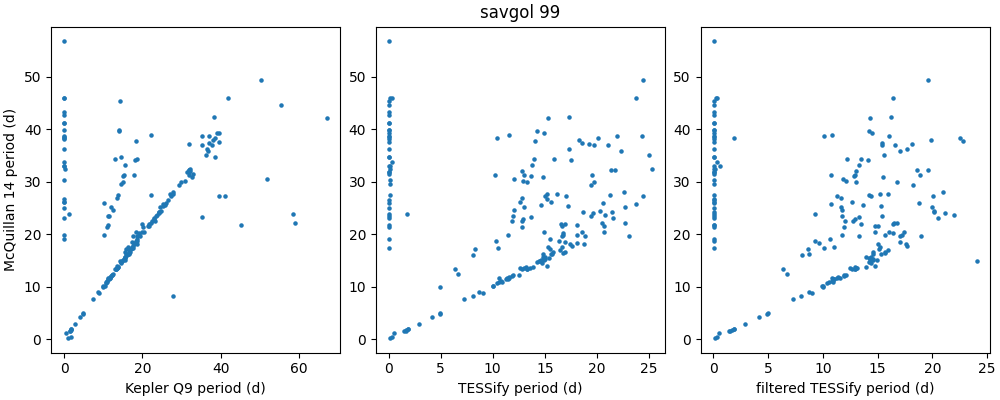

In [21]:
%matplotlib notebook

fig, ax = plt.subplots(1,3, figsize=(10,4), constrained_layout=True)

ax[0].scatter(periods_k, p_r, s=5)
ax[1].scatter(periods_t1, p_r, s=5)
ax[2].scatter(periods_t2, p_r, s=5)

ax[0].set(xlabel='Kepler Q9 period (d)', ylabel='McQuillan 14 period (d)')
ax[1].set(xlabel='TESSify period (d)', title='savgol 99')
ax[2].set(xlabel='filtered TESSify period (d)')

plt.savefig('savgol99.png')